# µSAM - point prompts
Stuart in his third datarelease provided only points for cells.. Lets see what we can do with it

In [1]:
import sys, os; sys.path += [os.path.join(os.path.expanduser('~'), 'thesis')]  # NOTE hardcoded project root to find shared util modules

import os
import itertools as it
import json

import numpy as np
import pandas as pd
import skimage
import matplotlib.pyplot as plt

import micro_sam
from micro_sam import instance_segmentation, util

from util.label_studio_converter__brush import mask2rle
from util.plot import *

In [2]:
image = plt.imread("../data/third/1.jpg")

_annot = json.load(open('../data/third/annotations.json'))

def preprocess_point(annot):
  '''
    returns: dict: image → numpy instance segmentation mask
  '''

  out = pd.DataFrame()

  for result in annot[0]['annotations'][0]['result']:
    h,w = result['original_height'], result['original_width']
    # rot = result['image_rotation]

    x = result['value']['x']/100 * w
    y = result['value']['y']/100 * h
    s = result['value']['width']

    i = result['to_name']

    out = pd.concat([out, pd.DataFrame(dict(
      x=[x],
      y=[y],
    ))], ignore_index=True)

  return out

points = preprocess_point(_annot)

In [3]:

_cache_dir = os.path.join(os.path.expanduser('~'), '.cache', 'micro-sam')

dataset_id = 'third'

model = 'vit_h'
iou_thresh = 0.88

cache_dir = os.path.join(_cache_dir, dataset_id)
[os.makedirs(os.path.join(cache_dir, d), exist_ok=True) for d in 'embed masks rles'.split(' ')];

In [4]:
imgid = 1

predictor = util.get_sam_model(model_type=model)

pImage = f"../data/{dataset_id}/{imgid}.jpg"
pEmbed = f"{cache_dir}/embed.{model}.{imgid}.zarr"


print('LOADING'  if os.path.exists(pEmbed) else
      'WRITING', f'embedding cache at {pEmbed}')

embeddings = util.precompute_image_embeddings(
  predictor, image, ndim = 2, save_path=pEmbed,
  tile_shape=(tile:=1024, tile), halo=(halo:=tile//4, halo)
)

LOADING embedding cache at /gpfs/space/home/eckhardt/.cache/micro-sam/third/embed.vit_h.1.zarr


In [5]:

r = 12 # make negative dummy points in this radius to force masks to be smaller

_points = points
points = points.to_numpy()


insts_points = [
  micro_sam.prompt_based_segmentation.segment_from_points(
    predictor=predictor,
    image_embeddings=embeddings,
    points=np.array([[x,y], [x-r,y-r], [x-r,y+r], [x+r,y+r], [x+r,y-r]]),
    labels=np.array([1,0,0,0,0]),
  )[0] for x,y in points
]

masks = np.zeros(image.shape[:2])
for i, inst in enumerate(insts_points):
  masks[inst] = i+1

/gpfs/space/home/eckhardt/.micromamba/envs/micro-sam/lib/python3.11/site-packages/micro_sam/prompt_based_segmentation.py:162: UserWarning: 2 points were not in the tile and are dropped
  warnings.warn(
/gpfs/space/home/eckhardt/.micromamba/envs/micro-sam/lib/python3.11/site-packages/micro_sam/prompt_based_segmentation.py:162: UserWarning: 3 points were not in the tile and are dropped
  warnings.warn(


/gpfs/space/home/eckhardt/.micromamba/envs/micro-sam/lib/python3.11/site-packages/micro_sam/prompt_based_segmentation.py:162: UserWarning: 5 points were not in the tile and are dropped
  warnings.warn(


/tmp/ipykernel_166299/4154300795.py:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(points[:,0], points[:,1], edgecolors='black',


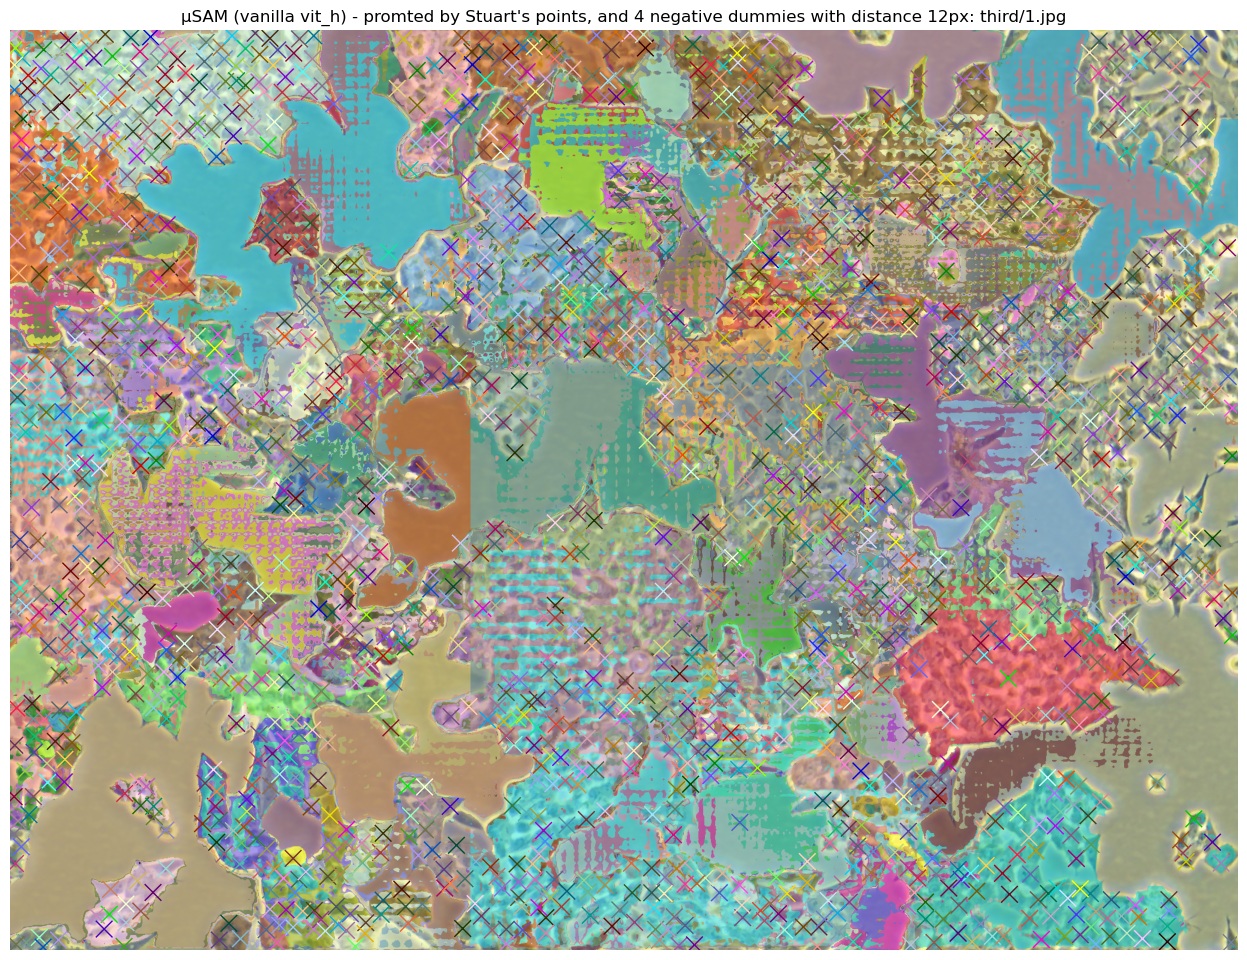

In [6]:

colors = colorcet.m_glasbey.colors
colors = list(it.islice(it.cycle(colors), len(points)))

fig, ax = plt.subplots(1,1, figsize=(13, 10))
plt.tight_layout()

ax.set_title(f"µSAM (vanilla vit_h) - promted by Stuart\'s points, and 4 negative dummies with distance {r}px: third/1.jpg")
ax.axis('off')

ax.imshow(skimage.color.label2rgb(
  masks, image, saturation=1, bg_color=None, alpha=0.5, colors=colors)
)

ax.scatter(points[:,0], points[:,1], edgecolors='black',
  s=r**2, c=colors, marker='x', linewidths=1)